# Pull all data and fit on it - classify artists

In [1]:
import random
import math
seed = 231
random.seed(seed) # fix the datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from painting_loader import PaintingFolder

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

import torchnet as tnt
from torchnet.meter import ConfusionMeter

import numpy as np
import timeit

%load_ext autoreload
%autoreload 2

dtype = torch.FloatTensor
ytype = torch.LongTensor
ytype_cuda = torch.cuda.LongTensor
if (torch.cuda.is_available()):
   dtype = torch.cuda.FloatTensor
print(ytype)
print(dtype)
print_every = 100

    
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def train(model, loss_fn, optimizer, loader_train, loader_val, train_acc, val_acc, num_epochs = 1):
    train_loss_hist = []
    # val_loss_hist = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # record training loss history
        train_loss_hist.append(loss)
            
        # record training and validation accuracy at the end of each epoch
        train_acc.append(check_accuracy(model, loader_train))
        val_acc.append(check_accuracy(model, loader_val))
        
    return [train_acc, val_acc, train_loss_hist]
    
def check_accuracy(model, loader):
    print('Checking accuracy!')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc

def check_accuracy_topX(model,loader, top=5):
    print('Checking top' + str(top) + ' accuracy!')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        
        s = scores.data.cpu().numpy()
        ind = np.argpartition(s, -top)[:, -top:]

        # crappy loop... must be a vectorized way to do this
        c = 0
        y_n = y.numpy()
        for i in np.arange(ind.shape[0]):
            if y[i,0] in ind[i]:
                c += 1
        
        num_correct += c
        num_samples += ind.shape[0]
        
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc    

def confusion_matrix(model, loader, conf):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(ytype)
        x_var = Variable(x.type(dtype), volatile=True)
        scores = model(x_var)
        
        conf.add(scores.data, y)

<class 'torch.LongTensor'>
<class 'torch.cuda.FloatTensor'>


# Prep the data

In [3]:
## ALL MAIN ARGUMENTS FOR THE SCRIPT ##

dat_folder = '../../Nitin/project/data/'
img_folder = dat_folder + 'images/'
num_workers = 4

filter_subset = False # True if we want to filter to just train _1
balanced_dset = True # True if I want equal # of paintings per artist, false if I want to use all available per artist

## THIS VERSION OF SCRIPT HAS EQUAL NUMBER OF PAINTINGS PER ARTIST
num_train = 240
num_val = 30
num_test = num_val
num_samples = num_train + num_val + num_test # threshold to include an artist
b_size = 60 # batch size for the data loaders


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob

t = pd.read_csv(dat_folder + 'all_data_info.csv')

# filter down (if needed)
if (filter_subset):
    t = t[t['new_filename'].str.startswith('1')]
    t = t[t['in_train']]

t.head()
# print(t.shape)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [5]:
x = list(t['artist'].value_counts())
# print(len([a for a in x if a >= 500]))

# 37 artists with more than 400 paintings
# 57 with more than 300
# 108 with more than 200

In [6]:
# list of all artists to include
temp = t['artist'].value_counts()
threshold = num_samples
# threshold = 500
artists = temp[temp >= threshold].index.tolist()
num_artists = len(artists)

print(str(len(artists)) + ' artists being classified')

# pull train and val data for just those artists
train_dfs = []
val_dfs = []
test_dfs = []

for a in artists:
    df = t[t['artist'].str.startswith(a, na=False)].sample(n=num_samples, random_state=seed)
    t_df = df.sample(n=num_train, random_state=seed)
    rest_df = df.loc[~df.index.isin(t_df.index)]
    v_df = rest_df.sample(n=num_val, random_state=seed)
    te_df = rest_df.loc[~rest_df.index.isin(v_df.index)]
    
    train_dfs.append(t_df)
    val_dfs.append(v_df)
    test_dfs.append(te_df)

train_df = pd.concat(train_dfs)
val_df = pd.concat(val_dfs)
test_df = pd.concat(test_dfs)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print("Done")

57 artists being classified
(13680, 12)
(1710, 12)
(1710, 12)
Done


In [7]:
mean_resnet = np.array([0.485, 0.456, 0.406])
std_resnet = np.array([0.229, 0.224, 0.225])
        
train_transform = T.Compose([
        T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean_resnet, std_resnet)
    ])
val_transform = T.Compose([
        T.Scale(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean_resnet, std_resnet)
    ])

train_dset = PaintingFolder(img_folder, train_transform, train_df)
loader_train = DataLoader(train_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)
    
val_dset = PaintingFolder(img_folder, val_transform, val_df)
loader_val = DataLoader(val_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)

test_dset = PaintingFolder(img_folder, val_transform, test_df)
loader_test = DataLoader(test_dset, batch_size=b_size, shuffle=True, num_workers=num_workers)

print("Done")

Done


# Simple network to use as a baseline

In [22]:
# Create a simple network to use as a baseline

simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # -> 112
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 56
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), # -> 28
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 14
    Flatten(),
    nn.Linear(6272, 4*num_artists),
    nn.ReLU(inplace=True),
    nn.Linear(4*num_artists, num_artists),
)

for m in simple_model.modules():
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
                
if torch.cuda.is_available():
    simple_model = simple_model.cuda()

simple_model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)

In [23]:
simple_model.load_state_dict(torch.load('/home/Nitin/project/cs231n-final/resnet18-300paintings/run2/simplenet/state_dict.dat'))
train_acc_simple, val_acc_simple = torch.load('/home/Nitin/project/cs231n-final/resnet18-300paintings/run2/simplenet/train_val_accs.dat')

In [12]:
# Now we're going to feed a random batch into the model and make sure the output is the right size
x = torch.randn(64, 3, 224, 224).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = simple_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, num_artists]))

True

In [10]:
# apply my simple network to the dataset
reset(simple_model)

train_acc_simple = []
val_acc_simple = []
train_loss_simple = []

In [12]:
optimizer = optim.Adam(simple_model.parameters(), lr=1e-5)
train_acc_simple, val_acc_simple, train_loss_simple = train(simple_model, loss_fn, optimizer, loader_train, loader_val, train_acc_simple, val_acc_simple, num_epochs = 1)

Starting epoch 1 / 1
t = 100, loss = 2.3515
t = 200, loss = 1.8804
Checking accuracy!
Got 5977 / 13680 correct (43.69)
Checking accuracy!
Got 763 / 1710 correct (44.62)


In [14]:
print(train_acc_simple)
torch.save(simple_model.state_dict(), 'simplenet/state_dict.dat')
torch.save([train_acc_simple, val_acc_simple], 'simplenet/train_val_accs.dat')

[19.283625730994153, 24.86111111111111, 26.71783625730994, 29.912280701754383, 31.71783625730994, 33.14327485380117, 33.260233918128655, 35.15350877192983, 36.68859649122807, 34.76608187134503, 41.54970760233918, 41.76169590643275, 42.675438596491226, 42.58771929824562, 42.84356725146199, 43.640350877192986, 43.691520467836256]


## Training accuracy over time chart


[19.283625730994153, 24.86111111111111, 26.71783625730994, 29.912280701754383, 31.71783625730994, 33.14327485380117, 33.260233918128655, 35.15350877192983, 36.68859649122807, 34.76608187134503, 41.54970760233918, 41.76169590643275, 42.675438596491226, 42.58771929824562, 42.84356725146199]
[21.403508771929825, 24.853801169590643, 28.421052631578945, 31.69590643274854, 32.98245614035088, 34.26900584795322, 34.152046783625735, 35.67251461988304, 38.59649122807017, 35.67251461988304, 41.75438596491228, 42.10526315789473, 42.280701754385966, 43.50877192982456, 43.684210526315795]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


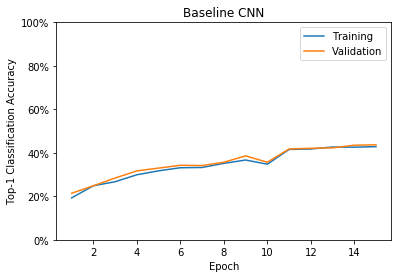

In [34]:
epochs = np.arange(len(train_acc_simple)) + 1
print(train_acc_simple)
print(val_acc_simple)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_acc_simple)
plt.plot(epochs, val_acc_simple)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Classification Accuracy')
plt.title('Baseline CNN')
plt.legend(['Training', 'Validation'])

# y ticks
plt.gca().set_ylim(ymin=0, ymax=100)
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# x ticks
# vals = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:0.0f}'.format(x) for x in vals])

plt.show()

In [36]:
check_accuracy(simple_model, loader_test)
check_accuracy_topX(simple_model, loader_test, top=3)

Checking accuracy!
Got 722 / 1710 correct (42.22)
Checking top3 accuracy!
Got 1065 / 1710 correct (62.28)


62.28070175438597

In [15]:
torch.save(simple_model.state_dict(), 'simplenet/state_dict.dat')
torch.save([train_acc_simple, val_acc_simple], 'simplenet/train_val_accs.dat')

### Precision/recall for simpleNet


In [18]:
conf_simple = ConfusionMeter(num_artists, normalized=False)
confusion_matrix(simple_model, loader_test, conf_simple)

In [20]:
conf_simple_arr = conf_simple.value()
true_positives = conf_simple_arr.diagonal()

# precision for a class = (# of correct predictions for class) / all predictions of that class sum over column)
col_sums = np.sum(conf_simple_arr, axis=0)
precision = true_positives / col_sums

# recall for a class = (# of correct predictions for class) / # of elements of that class (sum over row)
row_sums = np.sum(conf_simple_arr, axis=1)
recall = true_positives / row_sums

F_score = 2*precision*recall/(precision+recall)

avg_Fscore = np.mean(F_score)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)

print(avg_Fscore)
print(avg_precision)
print(avg_recall)

(57,)
0.360233629385
0.4161895982
0.366081871345


# ResNet-18 transfer learning

In [8]:
import torchvision 

# transfer learning on top of ResNet (only replacing final FC layer)
# model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_artists)

if torch.cuda.is_available():
    model_conv = model_conv.cuda()

loss_fn = nn.CrossEntropyLoss().type(dtype)

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-3)

In [9]:
model_conv.load_state_dict(torch.load('../../Nitin/project/cs231n-final/resnet18-300paintings/run2/state_dict.dat'))
train_acc, val_acc = torch.load('../../Nitin/project/cs231n-final/resnet18-300paintings/run2/train_val_accs.dat')

In [72]:
train_acc = []
val_acc = []

start_time = timeit.default_timer()
train_acc, val_acc, train_loss = train(model_conv, loss_fn, optimizer_conv, loader_train, loader_val, train_acc, val_acc, num_epochs = 5)

print()
print(str(timeit.default_timer() - start_time) + " seconds taken")

Starting epoch 1 / 5
t = 100, loss = 2.9024
t = 200, loss = 2.6586
Checking accuracy!
Got 6091 / 13680 correct (44.52)
Checking accuracy!
Got 772 / 1710 correct (45.15)
Starting epoch 2 / 5
t = 100, loss = 2.2287
t = 200, loss = 2.0371
Checking accuracy!
Got 6969 / 13680 correct (50.94)
Checking accuracy!
Got 860 / 1710 correct (50.29)
Starting epoch 3 / 5
t = 100, loss = 1.9976
t = 200, loss = 2.1574
Checking accuracy!
Got 7349 / 13680 correct (53.72)
Checking accuracy!
Got 911 / 1710 correct (53.27)
Starting epoch 4 / 5
t = 100, loss = 1.8036
t = 200, loss = 1.7696
Checking accuracy!
Got 7763 / 13680 correct (56.75)
Checking accuracy!
Got 963 / 1710 correct (56.32)
Starting epoch 5 / 5
t = 100, loss = 1.7888
t = 200, loss = 1.7348
Checking accuracy!
Got 7873 / 13680 correct (57.55)
Checking accuracy!
Got 986 / 1710 correct (57.66)

1691.010693234999 seconds taken


In [12]:
# now we allow all of the network to change, but by less
for param in model_conv.parameters():
    param.requires_grad = True

optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-4, weight_decay=1e-2)

start_time = timeit.default_timer()
train_acc, val_acc, train_loss = train(model_conv, loss_fn, optimizer_conv, loader_train, loader_val, train_acc, val_acc, num_epochs = 3)

print()
print(str(timeit.default_timer() - start_time) + " seconds taken")

Starting epoch 1 / 3
t = 100, loss = 0.3119
t = 200, loss = 0.6306
Checking accuracy!
Got 11993 / 13680 correct (87.67)
Checking accuracy!
Got 1265 / 1710 correct (73.98)
Starting epoch 2 / 3
t = 100, loss = 0.4637
t = 200, loss = 0.6597
Checking accuracy!
Got 11899 / 13680 correct (86.98)
Checking accuracy!
Got 1292 / 1710 correct (75.56)
Starting epoch 3 / 3
t = 100, loss = 0.3687
t = 200, loss = 0.5498
Checking accuracy!
Got 11906 / 13680 correct (87.03)
Checking accuracy!
Got 1272 / 1710 correct (74.39)

1058.281781397 seconds taken


In [31]:
# check_accuracy(model_conv, loader_train)
# check_accuracy(model_conv, loader_val)
check_accuracy(model_conv, loader_test)

Checking accuracy!
Got 1328 / 1710 correct (77.66)


77.6608187134503

In [ ]:
check_accuracy_topX(model_conv, loader_train, top=3)

In [62]:
check_accuracy_topX(model_conv, loader_val, top=3)
check_accuracy_topX(model_conv, loader_test, top=3)

Checking top3 accuracy!
Got 1557 / 1710 correct (91.05)
Checking top3 accuracy!
Got 1536 / 1710 correct (89.82)


89.82456140350877

[45.07309941520467, 50.79678362573099, 54.21783625730994, 56.50584795321637, 57.43421052631579, 70.46783625730994, 76.17690058479532, 79.97076023391813, 82.58771929824562, 84.01315789473685, 85.29239766081871, 90.02192982456141, 90.72368421052632, 87.953216374269, 88.66959064327486, 89.10087719298245, 87.66812865497076, 86.98099415204679, 87.03216374269006]
[45.90643274853801, 52.10526315789473, 56.54970760233918, 55.73099415204679, 57.36842105263158, 66.4327485380117, 70.87719298245614, 73.74269005847952, 74.61988304093568, 74.26900584795322, 73.9766081871345, 77.77777777777779, 77.89473684210526, 74.03508771929825, 76.19883040935672, 76.14035087719299, 73.9766081871345, 75.55555555555556, 74.3859649122807]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


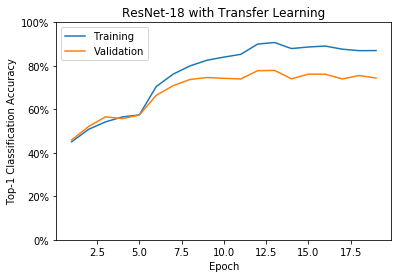

In [13]:
epochs = np.arange(len(train_acc)) + 1
print(train_acc)
print(val_acc)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Classification Accuracy')
plt.title('ResNet-18 with Transfer Learning')
plt.legend(['Training', 'Validation'])

# y ticks
plt.gca().set_ylim(ymin=0, ymax=100)
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# x ticks
# vals = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:0.0f}'.format(x) for x in vals])

plt.show()

## Saliency maps of ResNet-18 images

In [21]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; Lo
    
    Tensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y).type(ytype_cuda)
 
    scores = model(X_var)
    correct_scores = scores.gather(1, y_var.view(-1, 1)).squeeze()
    loss = torch.sum(correct_scores)
    
    loss.backward()
    
    gradient = torch.abs(X_var.grad.data)
    maxs, _ = torch.max(gradient, dim=1)
    saliency = maxs.squeeze()
    
    return saliency

def show_saliency_maps(dataset, model, numImages=4):
    """
    dataset should be a Dataset that we want to pull images from
    """
    
    model.eval()
    
    data_loader = DataLoader(dataset, batch_size=numImages, shuffle=True)
    
    X_tensor = None
    y_tensor = None
    for x, y in data_loader:
        X_tensor = x.type(dtype)
        y_tensor = y.view(-1, 1).type(ytype)
        X = X_tensor.cpu().numpy()
        y = y_tensor.cpu().numpy()[:,0]
        break

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    class_names = dataset.idx_to_class
    
    N = numImages
    for i in range(N):
        plt.subplot(2, N, i + 1)
        img = X[i].transpose(1,2,0)
        
        img = img*std_resnet + mean_resnet
    
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

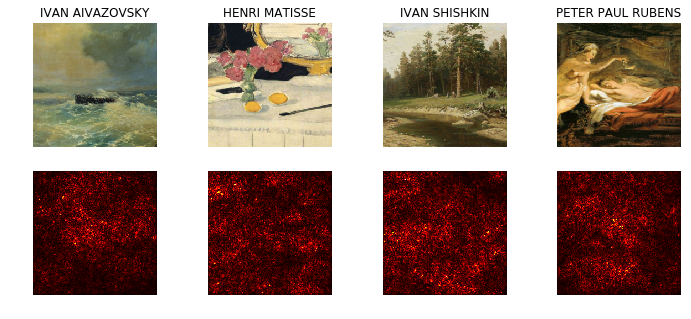

In [18]:
# before making the saliency map, set model as final so we don't calculate gradients for it
for param in model_conv.parameters():
    param.requires_grad = False
    
show_saliency_maps(train_dset, model_conv, numImages=4)

## Saliency map of one particular artist

In [20]:
# find a few artists with distinctive styles - e.g. Van gogh, Durer, etc.
# picasso = 39
# dali = 48
# van gogh = 53
# gauigin = 41
# cezanne = 40
print(test_dset.idx_to_class)

{0: 'ALBERT BIERSTADT', 1: 'ALBRECHT DURER', 2: 'ALFRED SISLEY', 3: 'AMEDEO MODIGLIANI', 4: 'BORIS KUSTODIEV', 5: 'CAMILLE COROT', 6: 'CAMILLE PISSARRO', 7: 'CHILDE HASSAM', 8: 'CLAUDE MONET', 9: 'DAVID BURLIUK', 10: 'EDGAR DEGAS', 11: 'ERNST LUDWIG KIRCHNER', 12: 'ERTE', 13: 'EUGENE BOUDIN', 14: 'EYVIND EARLE', 15: 'FELIX VALLOTTON ', 16: 'FERNAND LEGER', 17: 'FRANCISCO GOYA', 18: 'GIOVANNI BATTISTA PIRANESI', 19: 'GUSTAVE DORE', 20: 'HENRI DE TOULOUSE-LAUTREC', 21: 'HENRI MARTIN', 22: 'HENRI MATISSE', 23: 'ILYA REPIN', 24: 'ISAAC LEVITAN', 25: 'IVAN AIVAZOVSKY', 26: 'IVAN SHISHKIN', 27: 'JAMES TISSOT', 28: 'JOHN SINGER SARGENT', 29: 'KONSTANTIN KOROVIN', 30: 'KONSTANTIN MAKOVSKY', 31: 'M.C. ESCHER', 32: 'MARC CHAGALL', 33: 'MARTIROS SARYAN', 34: 'MARY CASSATT', 35: 'MAURICE PRENDERGAST', 36: 'MAX ERNST', 37: 'NICHOLAS ROERICH', 38: 'ODILON REDON', 39: 'PABLO PICASSO', 40: 'PAUL CEZANNE', 41: 'PAUL GAUGUIN', 42: 'PETER PAUL RUBENS', 43: 'PIERRE-AUGUSTE RENOIR', 44: 'PYOTR KONCHALOVSKY

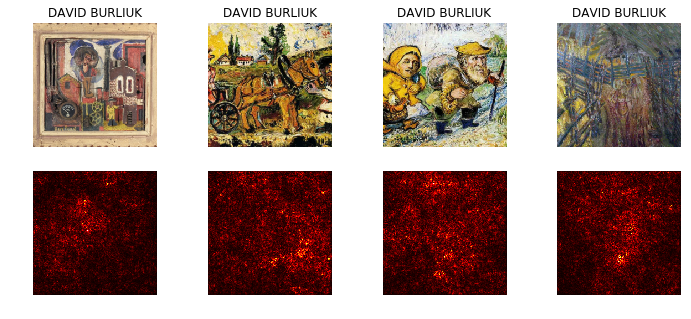

In [34]:
# make a new dataset that just has paintings of this artist
idx = 9 # picasso
artist_idx = test_dset.idx_to_class

artist = artist_idx[idx]

df = t[t['artist'].str.upper().str.startswith(artist, na=False)].sample(n=num_samples, random_state=seed)
t_df = df.sample(n=num_train, random_state=seed)
rest_df = df.loc[~df.index.isin(t_df.index)]
v_df = rest_df.sample(n=num_val, random_state=seed)
test_df = rest_df.loc[~rest_df.index.isin(v_df.index)]

artist_dset = PaintingFolder(img_folder, val_transform, test_df)

# call my saliency code on just this artist
for param in model_conv.parameters():
    param.requires_grad = False
    
show_saliency_maps(artist_dset, model_conv, numImages=4)

## Confusion Matrix

In [37]:
conf_test = ConfusionMeter(num_artists, normalized=False)
confusion_matrix(model_conv, loader_test, conf_test)

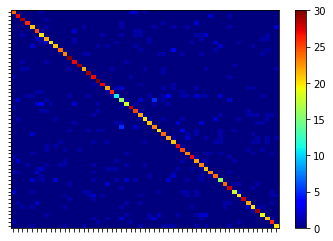

In [38]:
conf_arr = conf_test.value()

# from https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, 
                interpolation='nearest', aspect ='auto')

width, height = conf_arr.shape


for x in np.arange(width):
    for y in np.arange(height):
        pass
        # ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
        #            horizontalalignment='center',
        #            verticalalignment='center')

cb = fig.colorbar(res)
alphabet = ''
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.show()

In [44]:
print(conf_arr)
print(test_dset.idx_to_class)

print(conf_arr[22])

# Levitan is often confused
# He primarily does landscapes which other painters do as well - not confused necessarily because of style, but because of the style of work
# not a heavy confusion with 1 specific artist, it is spread out over many

[[24  0  0 ...,  0  0  0]
 [ 0 27  0 ...,  0  0  0]
 [ 0  0 29 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 21  1  0]
 [ 1  0  0 ...,  0 26  0]
 [ 0  0  0 ...,  0  0 20]]
{0: 'ALBERT BIERSTADT', 1: 'ALBRECHT DURER', 2: 'ALFRED SISLEY', 3: 'AMEDEO MODIGLIANI', 4: 'BORIS KUSTODIEV', 5: 'CAMILLE COROT', 6: 'CAMILLE PISSARRO', 7: 'CHILDE HASSAM', 8: 'CLAUDE MONET', 9: 'DAVID BURLIUK', 10: 'EDGAR DEGAS', 11: 'ERNST LUDWIG KIRCHNER', 12: 'ERTE', 13: 'EUGENE BOUDIN', 14: 'EYVIND EARLE', 15: 'FELIX VALLOTTON ', 16: 'FERNAND LEGER', 17: 'FRANCISCO GOYA', 18: 'GIOVANNI BATTISTA PIRANESI', 19: 'GUSTAVE DORE', 20: 'HENRI DE TOULOUSE-LAUTREC', 21: 'HENRI MARTIN', 22: 'HENRI MATISSE', 23: 'ILYA REPIN', 24: 'ISAAC LEVITAN', 25: 'IVAN AIVAZOVSKY', 26: 'IVAN SHISHKIN', 27: 'JAMES TISSOT', 28: 'JOHN SINGER SARGENT', 29: 'KONSTANTIN KOROVIN', 30: 'KONSTANTIN MAKOVSKY', 31: 'M.C. ESCHER', 32: 'MARC CHAGALL', 33: 'MARTIROS SARYAN', 34: 'MARY CASSATT', 35: 'MAURICE PRENDERGAST', 36: 'MAX ERNST', 37: 'NICHOLAS ROER

## Precision and recall (using confusion matrix data)

In [51]:
true_positives = conf_arr.diagonal()

# precision for a class = (# of correct predictions for class) / all predictions of that class sum over column)
col_sums = np.sum(conf_arr, axis=0)
precision = true_positives / col_sums

# recall for a class = (# of correct predictions for class) / # of elements of that class (sum over row)
row_sums = np.sum(conf_arr, axis=1)
recall = true_positives / row_sums

F_score = 2*precision*recall/(precision+recall)

avg_Fscore = np.mean(F_score)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)

print(F_score.shape)
print(avg_Fscore)
print(avg_precision)
print(avg_recall)

(57,)
0.771777948131
0.777158745386
0.774269005848
[ 0.8         0.9         0.96666667  0.86666667  0.73333333  0.83333333
  0.66666667  0.73333333  0.66666667  0.66666667  0.8         0.76666667
  1.          0.9         0.96666667  0.73333333  0.96666667  0.9         1.
  0.9         0.73333333  0.86666667  0.36666667  0.53333333  0.6
  0.93333333  0.83333333  0.73333333  0.66666667  0.7         0.76666667
  0.66666667  0.76666667  0.73333333  0.7         0.9         0.83333333
  0.76666667  0.9         0.73333333  0.76666667  0.66666667  0.73333333
  0.76666667  0.53333333  0.8         0.93333333  0.6         0.66666667
  0.93333333  0.73333333  0.66666667  0.96666667  0.63333333  0.7
  0.86666667  0.66666667]


## Confusion matrix analysis

In [ ]:
# Map recall and precision values to the different artists
# look at artists with high/low recall, understand why this is the case

# for ones with low recall, look at where the confusion happened - what artists were they classified to instead?
# was low recall also true in the opposite direction, or just one way?

# for low precision, look at artists who seemed to get a lot of predictions (lots of work was labeled as theirs when it isn't)

# ResNet trained from scratch

In [25]:
import torchvision 

# transfer learning on top of ResNet (only replacing final FC layer)
model_scratch = torchvision.models.resnet18(pretrained=False)
for param in model_scratch.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, num_artists)

if torch.cuda.is_available():
    model_scratch = model_scratch.cuda()

loss_fn = nn.CrossEntropyLoss().type(dtype)

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=1e-3)
#train_scratch = []
#val_scratch = []

model_scratch.load_state_dict(torch.load('scratch/scratch_state_dict.dat'))
train_scratch, val_scratch = torch.load('scratch/scratch_train_val_accs.dat')


In [9]:
start_time = timeit.default_timer()
train_scratch, val_scratch, train_loss = train(model_scratch, loss_fn, optimizer_scratch, loader_train, loader_val, train_scratch, val_scratch, num_epochs = 10)

print()
print(str(timeit.default_timer() - start_time) + " seconds taken")

Starting epoch 1 / 10
t = 100, loss = 3.6690
t = 200, loss = 3.4765
Checking accuracy!
Got 1591 / 13680 correct (11.63)
Checking accuracy!
Got 219 / 1710 correct (12.81)
Starting epoch 2 / 10
t = 100, loss = 3.4230
t = 200, loss = 3.2983
Checking accuracy!
Got 2182 / 13680 correct (15.95)
Checking accuracy!
Got 285 / 1710 correct (16.67)
Starting epoch 3 / 10
t = 100, loss = 3.0066
t = 200, loss = 3.1131
Checking accuracy!
Got 2822 / 13680 correct (20.63)
Checking accuracy!
Got 368 / 1710 correct (21.52)
Starting epoch 4 / 10
t = 100, loss = 3.1046
t = 200, loss = 2.8146
Checking accuracy!
Got 3403 / 13680 correct (24.88)
Checking accuracy!
Got 451 / 1710 correct (26.37)
Starting epoch 5 / 10
t = 100, loss = 2.6365
t = 200, loss = 3.0496
Checking accuracy!
Got 3432 / 13680 correct (25.09)
Checking accuracy!
Got 419 / 1710 correct (24.50)
Starting epoch 6 / 10
t = 100, loss = 2.5038
t = 200, loss = 2.8063
Checking accuracy!
Got 4200 / 13680 correct (30.70)
Checking accuracy!
Got 519 / 1

In [12]:
optimizer_scratch2 = optim.Adam(model_scratch.parameters(), lr=1e-3)
train_scratch, val_scratch, train_loss = train(model_scratch, loss_fn, optimizer_scratch2, loader_train, loader_val, train_scratch, val_scratch, num_epochs = 2)

Starting epoch 1 / 2
t = 100, loss = 3.7394
t = 200, loss = 3.3196
Checking accuracy!
Got 2024 / 13680 correct (14.80)
Checking accuracy!
Got 252 / 1710 correct (14.74)
Starting epoch 2 / 2
t = 100, loss = 3.3154
t = 200, loss = 3.0586
Checking accuracy!
Got 2547 / 13680 correct (18.62)
Checking accuracy!
Got 334 / 1710 correct (19.53)


[11.630116959064328, 15.950292397660817, 20.628654970760234, 24.875730994152047, 25.087719298245613, 30.701754385964914, 34.130116959064324, 34.66374269005848, 34.53216374269006, 34.45906432748538, 47.06140350877193, 48.764619883040936, 48.51608187134503, 49.18859649122807, 50.62134502923976, 51.08918128654971, 51.41081871345029, 51.96637426900585]
[12.80701754385965, 16.666666666666664, 21.52046783625731, 26.374269005847957, 24.502923976608187, 30.350877192982455, 34.85380116959064, 35.55555555555556, 34.619883040935676, 36.432748538011694, 46.4327485380117, 47.251461988304094, 47.66081871345029, 48.30409356725146, 49.122807017543856, 50.0, 50.58479532163743, 50.058479532163744]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


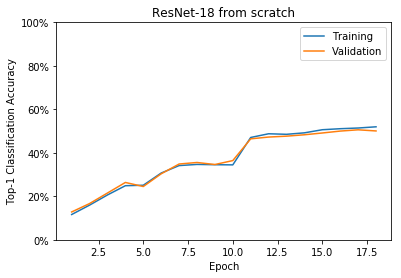

In [32]:
epochs = np.arange(len(train_scratch)) + 1
print(train_scratch)
print(val_scratch)
print(epochs)

# Plot the points using matplotlib
plt.plot(epochs, train_scratch)
plt.plot(epochs, val_scratch)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Classification Accuracy')
plt.title('ResNet-18 from scratch')
plt.legend(['Training', 'Validation'])

# y ticks
plt.gca().set_ylim(ymin=0, ymax=100)
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in vals])

# x ticks
# vals = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:0.0f}'.format(x) for x in vals])

plt.show()

In [33]:
check_accuracy(model_scratch, loader_test)
check_accuracy_topX(model_scratch, loader_test, top=3)

Checking accuracy!
Got 874 / 1710 correct (51.11)
Checking top3 accuracy!
Got 1214 / 1710 correct (70.99)


70.99415204678363

In [10]:
torch.save(model_scratch.state_dict(), 'scratch/scratch_state_dict.dat')
torch.save([train_scratch, val_scratch], 'scratch/scratch_train_val_accs.dat')

### precision and recall

In [11]:
conf_scratch = ConfusionMeter(num_artists, normalized=False)
confusion_matrix(model_scratch, loader_test, conf_scratch)

conf_scratch_arr = conf_scratch.value()
true_positives = conf_scratch_arr.diagonal()

# precision for a class = (# of correct predictions for class) / all predictions of that class sum over column)
col_sums = np.sum(conf_scratch_arr, axis=0)
precision = true_positives / col_sums

# recall for a class = (# of correct predictions for class) / # of elements of that class (sum over row)
row_sums = np.sum(conf_scratch_arr, axis=1)
recall = true_positives / row_sums

F_score = 2*precision*recall/(precision+recall)

avg_Fscore = np.mean(F_score)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)

print(F_score.shape)
print(avg_Fscore)
print(avg_precision)
print(avg_recall)

(57,)
0.502764885136
0.515571587648
0.510526315789


# Maximize class score of two different artists (ResNet-18 xfer learning)
Pick two artists with very different styles of art. Starting from white noise, train an image to maximize their scores.

Artists: 

In [13]:
# pull list of artists so we can pick 2 - ideally picasso and van gogh
class_names = test_dset.class_to_idx
print(class_names)

# picasso = 39
# dali = 48
# van gogh = 53
# gauigin = 41
# cezanne = 40

{'THEODOR SEVERIN KITTELSEN': 50, 'REMBRANDT': 46, 'THEOPHILE STEINLEN': 51, 'FERNAND LEGER': 16, 'EUGENE BOUDIN': 13, 'UTAGAWA KUNIYOSHI': 52, 'GIOVANNI BATTISTA PIRANESI': 18, 'PAUL CEZANNE': 40, 'VINCENT VAN GOGH': 53, 'IVAN AIVAZOVSKY': 25, 'ZDISLAV BEKSINSKI': 55, 'EYVIND EARLE': 14, 'SAM FRANCIS': 49, 'JAMES TISSOT': 27, 'IVAN SHISHKIN': 26, 'KONSTANTIN KOROVIN': 29, 'ERNST LUDWIG KIRCHNER': 11, 'MAX ERNST': 36, 'ERTE': 12, 'SALVADOR DALI': 48, 'FRANCISCO GOYA': 17, 'ODILON REDON': 38, 'KONSTANTIN MAKOVSKY': 30, 'MAURICE PRENDERGAST': 35, 'GUSTAVE DORE': 19, 'ALBERT BIERSTADT': 0, 'CHILDE HASSAM': 7, 'NICHOLAS ROERICH': 37, 'JOHN SINGER SARGENT': 28, 'WILLIAM MERRITT CHASE': 54, 'HENRI MATISSE': 22, 'PAUL GAUGUIN': 41, 'AMEDEO MODIGLIANI': 3, 'EDGAR DEGAS': 10, 'BORIS KUSTODIEV': 4, 'PIERRE-AUGUSTE RENOIR': 43, 'ALFRED SISLEY': 2, 'DAVID BURLIUK': 9, 'PABLO PICASSO': 39, 'ISAAC LEVITAN': 24, 'FELIX VALLOTTON ': 15, 'MARC CHAGALL': 32, 'PYOTR KONCHALOVSKY': 44, 'CLAUDE MONET': 8, 

In [36]:
import scipy
from scipy.ndimage.filters import gaussian_filter1d

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X


def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X


def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.eval()
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    
    class_names = test_dset.idx_to_class

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    # img = torch.zeros(1, 3, 224, 224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        
        scores = model(img_var).squeeze()
        
        loss = scores[target_y] - l2_reg*torch.sum(img*img)
        loss.backward()
        
        gradient = img_var.grad.data
        gradient = learning_rate*gradient
        img += gradient

        # zero out the gradient for the next iteration
        img_var.grad.data.zero_()
        
        pass
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-mean_resnet[c] / std_resnet[c])
            hi = float((1.0 - mean_resnet[c]) / std_resnet[c])
            img[:, c].clamp_(min=lo, max=hi)
            if t % blur_every == 0:
                blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            print(scores[target_y].data[0])
            print(torch.max(scores).data[0])
        
            img_copy = img.clone().cpu().squeeze().numpy().transpose(1,2,0)
            img_copy = img_copy*std_resnet + mean_resnet
            
            plt.imshow(img_copy)
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    # return img.cpu()

-3.886521577835083
-3.441667318344116


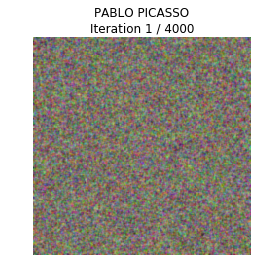

-1.9867935180664062
-1.9867935180664062


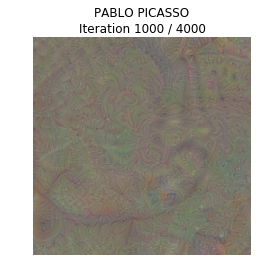

-2.198655128479004
-2.198655128479004


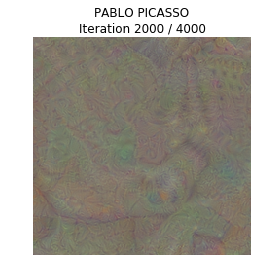

-2.012108087539673
-2.012108087539673


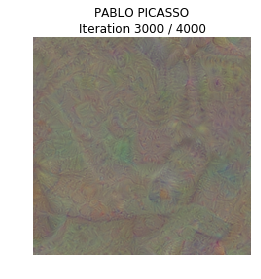

-1.9909844398498535
-1.9909844398498535


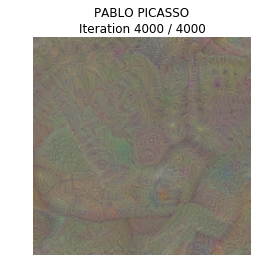

In [37]:
for param in model_conv.parameters():
    param.requires_grad = False

target_y = 39 # picasso
out = create_class_visualization(target_y, model_conv, dtype, blur_every=10, l2_reg=1e-3, learning_rate=5, num_iterations=4000, show_every=1000)


-5.062132358551025
-3.4160306453704834


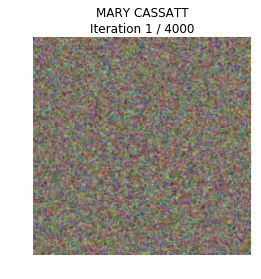

-3.5999677181243896
-3.5999677181243896


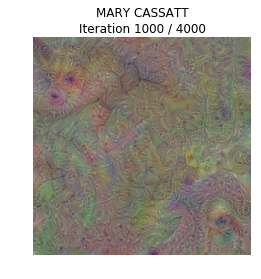

-3.9052412509918213
-3.518524169921875


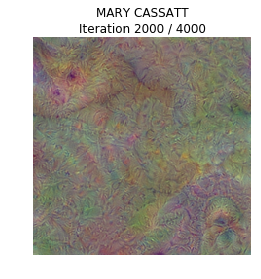

-3.622554302215576
-3.596879243850708


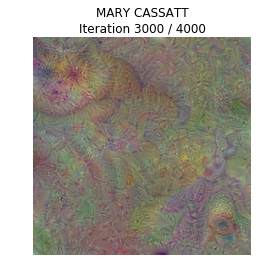

-3.738706350326538
-3.625117301940918


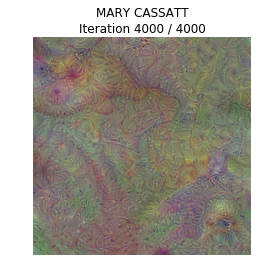

In [30]:
for param in model_conv.parameters():
    param.requires_grad = False

target_y = 34 # cassatt
out = create_class_visualization(target_y, model_conv, dtype, blur_every=5, l2_reg=1e-3, learning_rate=25, num_iterations=4000, show_every=1000)


# Take a style-transferred image and see if network is fooled (from resnet xfer)

MAX ERNST
[19 31 14 36  9]
[ 0.5854364   1.19465625  2.75884318  4.29565001  0.99491704]
GUSTAVE DORE
M.C. ESCHER
EYVIND EARLE
MAX ERNST
DAVID BURLIUK


(-0.5, 223.5, 223.5, -0.5)

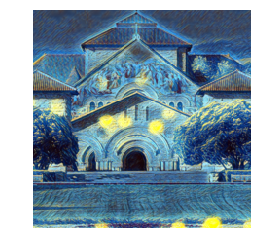

In [35]:
path = 'out.png'#TBD - path to image

f = open(path, 'rb')
img = Image.open(f)
img = img.convert('RGB')
        
model_conv.eval()

t_img = val_transform(img)

crop = t_img.cpu().numpy().transpose(1,2,0)
crop = crop*std_resnet + mean_resnet
plt.imshow(crop)

t_img = t_img.view(1, 3, 224, 224)
img_var = Variable(t_img, volatile=True).type(dtype)

scores = model_conv(img_var).squeeze()

_, idx = torch.max(scores, dim=0)

# print(test_dset.idx_to_class)
print(test_dset.idx_to_class[idx.data[0]])

s = scores.data.cpu().numpy()
ind = np.argpartition(s, -5)[-5:] # get the indices of the 5 largest elements
print(ind)
print(s[ind])

for i in ind:
    print(test_dset.idx_to_class[i])

# plt.imshow(img)
plt.axis('off')